In [2]:
#import all necessary packages
import scipy as sp
import numpy as np
import pandas as pd
import sklearn
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta, datetime
import re
import timeit


pd.options.display.max_rows = 4000

In [3]:
#according to USC regions listed
#may exclude outliers present in UMich 

#pull data from skasrali/UMich github
df = pd.read_csv('https://raw.githubusercontent.com/skasralikar/Risk-Score-1-UMichZJU/master/data/output/LA-daily-out.csv')

#USC
df_cases = pd.read_csv('https://raw.githubusercontent.com/ANRGUSC/covid19_risk_estimation/master/data/Covid-19.csv')

#Converting String into Datatime data type
df['Time Stamp'] = pd.to_datetime(df['Timestamp'])
df_cases['Time Stamp'] = pd.to_datetime(df_cases['Time Stamp'])

#Drop duplicate timestamp column
df = df.drop(['Timestamp'], axis = 1)

#Drop Latitude and Longitude from df_cases
df_cases = df_cases.drop(['Latitude', 'Longitude'], axis = 1)

#merge two tables
df = pd.merge(df, df_cases, how = 'left', left_on = ['Time Stamp','Region'], right_on = ['Time Stamp', 'Region'])


In [4]:
df

,Unnamed: 0,Region,Risk_score_level,Risk_score,Time Stamp,Number of cases
0,0,Acton,0,-24.587520,2020-04-09,5.0
1,1,Acton,0,-26.030156,2020-04-10,5.0
2,2,Acton,0,-22.628911,2020-04-11,5.0
3,3,Acton,0,-23.349784,2020-04-12,5.0
4,4,Acton,0,-18.503235,2020-04-13,0.0
...,...,...,...,...,...,...
22507,22507,Woodland Hills,3,110.682546,2020-08-18,750.0
22508,22508,Woodland Hills,3,114.700589,2020-08-19,751.0
22509,22509,Woodland Hills,3,114.065112,2020-08-20,754.0
22510,22510,Woodland Hills,3,113.116975,2020-08-21,757.0


In [5]:
#check for/drop nulls
df.isnull()
df = df.dropna()

In [6]:
#Kooha drops any data with no risk score 
#no risk score = negative risk score
#in case of UMich, risk score level 0 = negative risk score
#risk score levels could be recategorized for more accurate results

#Drop negative risk scores
#df=df[df['Risk-Score']!=-1]

#Convert string into datetime data type
df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])

#rename columns 
df = df.rename(columns = {"Unnamed: 0": "index", "Risk_score_level": "Risk-Level", "Risk_score" : "Risk-Score"})


C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [7]:
#Define LA county and LA city

df_countynames = pd.read_csv('county_storage.csv')

uregions = df_countynames['location'].unique()
pattern = "^LOS ANGELES - "
extr_region = df_countynames['location'].str.contains(pattern)

LAregion = df_countynames[extr_region]['location']
LAregion = LAregion.str.replace('LOS ANGELES - ', '').unique()

LAregion

array(['ADAMS-NORMANDIE', 'ALSACE', 'ANGELINO HEIGHTS', 'ARLETA',
       'ATWATER VILLAGE', 'BALDWIN HILLS', 'BEL AIR', 'BEVERLY CREST',
       'BEVERLYWOOD', 'BOYLE HEIGHTS', 'BRENTWOOD', 'BROOKSIDE',
       'CADILLAC-CORNING', 'CANOGA PARK', 'CARTHAY', 'CENTRAL',
       'CENTURY CITY', 'CENTURY PALMS/COVE', 'CHATSWORTH',
       'CHEVIOT HILLS', 'CHINATOWN', 'CLOVERDALE/COCHRAN',
       'COUNTRY CLUB PARK', 'CRENSHAW DISTRICT', 'CRESTVIEW', 'DEL REY',
       'DOWNTOWN', 'EAGLE ROCK', 'EAST HOLLYWOOD', 'ECHO PARK',
       'EL SERENO', 'ELYSIAN PARK', 'ELYSIAN VALLEY', 'ENCINO',
       'EXPOSITION', 'EXPOSITION PARK', 'FAIRCREST HEIGHTS',
       'FIGUEROA PARK SQUARE', 'FLORENCE-FIRESTONE', 'GLASSELL PARK',
       'GRAMERCY PLACE', 'GRANADA HILLS', 'GREEN MEADOWS', 'HANCOCK PARK',
       'HARBOR CITY', 'HARBOR GATEWAY', 'HARBOR PINES', 'HARVARD HEIGHTS',
       'HARVARD PARK', 'HIGHLAND PARK', 'HISTORIC FILIPINOTOWN',
       'HOLLYWOOD', 'HOLLYWOOD HILLS', 'HYDE PARK', 'JEFFERSON PARK',

In [8]:
#create dataframe with new cases
regions = df['Region'].unique()
dfnew = df.copy()

dfnew

,index,Region,Risk-Level,Risk-Score,Time Stamp,Number of cases
0,0,Acton,0,-24.587520,2020-04-09,5.0
1,1,Acton,0,-26.030156,2020-04-10,5.0
2,2,Acton,0,-22.628911,2020-04-11,5.0
3,3,Acton,0,-23.349784,2020-04-12,5.0
4,4,Acton,0,-18.503235,2020-04-13,0.0
...,...,...,...,...,...,...
22507,22507,Woodland Hills,3,110.682546,2020-08-18,750.0
22508,22508,Woodland Hills,3,114.700589,2020-08-19,751.0
22509,22509,Woodland Hills,3,114.065112,2020-08-20,754.0
22510,22510,Woodland Hills,3,113.116975,2020-08-21,757.0


In [9]:
#Function for change in new cases
df_new_cases = pd.DataFrame()

for region in regions:
    df_region = dfnew[dfnew['Region'] == region].sort_values('Time Stamp')
    for date in df_region['Time Stamp']:
        day_before = date - dt.timedelta(days = 1)
        df_on_day = df_region[df_region['Time Stamp'] == date]
        
        cases_on_day = df_on_day['Number of cases']
        cases_day_before = df_region[df_region['Time Stamp'] == day_before]['Number of cases']
        if not cases_day_before.empty:
            new_cases = cases_on_day.iloc[0] - cases_day_before.iloc[0]
            new_row = {'index':df_on_day['index'].iloc[0], 'New Cases':new_cases}
            
            #append row to dataframe
            df_new_cases = df_new_cases.append(new_row, ignore_index = True)

In [10]:
df_new_cases.head()

,New Cases,index
0,0.0,1.0
1,0.0,2.0
2,0.0,3.0
3,-5.0,4.0
4,0.0,5.0


In [11]:
#Merge new cases data into current dataframe
df = pd.merge(left = df, right = df_new_cases, how = 'left', on = 'index')

In [12]:
df.head()

,index,Region,Risk-Level,Risk-Score,Time Stamp,Number of cases,New Cases
0,0,Acton,0,-24.587520,2020-04-09,5.0,NaN
1,1,Acton,0,-26.030156,2020-04-10,5.0,0.0
2,2,Acton,0,-22.628911,2020-04-11,5.0,0.0
3,3,Acton,0,-23.349784,2020-04-12,5.0,0.0
4,4,Acton,0,-18.503235,2020-04-13,0.0,-5.0


In [13]:
#Risk level definitions:
df_0 = df[df['Risk-Level']==0]['Risk-Score']
df_1 = df[df['Risk-Level']==1]['Risk-Score']
df_2 = df[df['Risk-Level']==2]['Risk-Score']
df_3 = df[df['Risk-Level']==3]['Risk-Score']

print("level 0 is between %f and %f" %(min(df_0),max(df_0)))
print("level 1 is between %f and %f" %(min(df_1),max(df_1)))
print("level 2 is between %f and %f" %(min(df_2),max(df_2)))
print("level 3 is between %f and %f" %(min(df_3),max(df_3)))

level 0 is between -1769.698123 and 0.096436
level 1 is between 0.101539 and 0.998674
level 2 is between 1.006675 and 1.999792
level 3 is between 2.001335 and 252652.847615


In [14]:
#Data Exploration

#according to risk score boxplot

#risk scores greater than 1000
test1 = df[df['Risk-Score'] > 1000]
#output: HARVARD PARK, WEST VERNON, VERNON CENTRAL, WHOLESALE DISTRICT

#risk scores less than 0
test2 = df[df['Risk-Score'] < -100]
#output: WEST VERNON, VERNON CENTRAL


In [15]:
#drop HARVARD PARK, WEST VERNON, VERNON CENTRAL, WHOLESALE DISTRICT

#hp = df[df['Region'].str.contains("Harvard Park")]
#wv = df[df['Region'].str.contains("West Vernon")]
#vc = df[df['Region'].str.contains("Vernon Central")]
#wd = df[df['Region'].str.contains("Wholesale District")]

#outlier_frames = [hp, wv, vc, wd]
#result = pd.concat(outlier_frames)

#df = pd.concat([df,result, result ]).drop_duplicates(keep=False)


In [16]:
#this definition returns an update dataframe with rolling average, rolling cases, and average cases

def calc_risk_trend(area, length1):
    df_recent_1= pd.DataFrame()
    df_rolling_1= pd.DataFrame()
    df_rolling_cases = pd.DataFrame()
    
    if area == 'LA COUNTY': # if 'all' is given, iterate through all regions in the data
        regions = 'LA COUNTY'
        df_mean = df.copy()
        df_mean = df_mean.groupby(["Time Stamp"]).mean()
        df_mean=df_mean.drop(['Number of cases','New Cases'], axis=1)
        df_sum = df.copy()
        df_sum = df_sum.groupby(["Time Stamp"]).sum()
        df_sum = df_sum[['Number of cases','New Cases']]
        df_new=df_sum.merge(df_mean, left_index=True, right_index=True, how='left')
        df_new['Region']='LA COUNTY'
        df_new['Time Stamp']=df_new.index
        df_new = df_new.set_index('index')
        
    elif area == 'LA CITY':
        df_la = df.copy()
        df_la = df_la[df_la['Region'].isin(los_angeles_region)]
        df_mean = df_la.copy()
        df_mean = df_mean.groupby(["Time Stamp"]).mean()
        df_mean=df_mean.drop(['Number of cases','New Cases'], axis=1)
        df_sum = df_la.copy()
        df_sum = df_sum.groupby(["Time Stamp"]).sum()
        df_sum = df_sum[['Number of cases','New Cases']]
        df_new=df_sum.merge(df_mean, left_index=True, right_index=True, how='left')
        df_new['Region']='LA CITY'
        df_new['Time Stamp']=df_new.index
        df_new = df_new.set_index('index')
        
    else:
        df_new=df.copy()
        df_new = df_new[df_new['Region']==area]
    
    df_region = df_new.sort_values('Time Stamp')
    
    # defining specific dates that we are going to pull data from
    recent_date = max(df_region['Time Stamp'])
    length1_bef = pd.to_datetime(recent_date) - dt.timedelta(days=length1)
    
    # pulling data matching dates defined
    df_1_before = df_region[df_region['Time Stamp'] == length1_bef]
    df_recent = df_region[df_region['Time Stamp']==recent_date]
    
    # calculating rolling averages
    rolling_rs_1 = df_region['Risk-Score'].rolling(length1, min_periods=1).mean()
    rolling_cases = df_region['New Cases'].rolling(length1, min_periods=1).mean()
    
    df_rolling_1 = df_rolling_1.append(rolling_rs_1)
    df_rolling_cases = df_rolling_cases.append(rolling_cases)
    
    df_rolling_1_sum = df_rolling_1.sum(skipna = True, axis=0)
    df_rolling_cases_sum = df_rolling_cases.sum(skipna = True, axis=0)
    

    rolling_1 = pd.DataFrame()
    rolling_c = pd.DataFrame()

    string3 = "Risk Score Rolling Avg"

    rolling_1[string3]=df_rolling_1_sum
    rolling_c['New Cases Rolling Avg']=df_rolling_cases_sum

    df_updated = df_region.merge(rolling_1, left_index=True, right_index=True, how='left')
    df_updated = df_updated.merge(rolling_c, left_index=True, right_index=True, how='left')

    df_updated = df_updated.sort_values('Time Stamp')
    
    return df_updated
        

In [17]:
# this function uses calc_risk_trend function to calculate the rolling average and creates a time-series plot
# this function only works when a specific region is given

def plot_rs(city_name,length1,plot_new_case_or_not):
    
    df_final = calc_risk_trend(city_name, length1)
    df_a = df[df['Region']==city_name].sort_values('Time Stamp')
    fig = plt.figure(figsize=(20,10))
    ax_left = fig.add_subplot()
    ax_right = ax_left.twinx()
    
    string3 = "Risk Score Rolling Avg"
    
    if plot_new_case_or_not == 'All':
    
        lns1 = ax_left.plot('Time Stamp','Risk-Score', data =df_final, color='black')
        lns2 = ax_left.plot('Time Stamp',string3, data =df_final, color='red')
        lns3 = ax_right.plot('Time Stamp','New Cases', data =df_final, color='green')
        lns4 = ax_right.plot('Time Stamp','New Cases Rolling Avg', data =df_final, color='blue')

        lns = lns1+lns2+lns3+lns4
        labs = [l.get_label() for l in lns]
        ax_left.legend(lns, labs, loc=2)

        ax_left.grid()
        ax_left.set_xlabel("Date",fontsize=15)
        ax_left.set_ylabel("Risk Score",fontsize=15)
        ax_right.set_ylabel("Number of New Cases",fontsize=15)

        df_new_case_drop=df_final.dropna(axis=0,subset=['New Cases'])

        y_max=max(df_final['Risk-Score'])
        y_max=y_max+y_max/10
        y_max_right = max(df_new_case_drop['New Cases'])
        y_max_right = y_max_right + y_max_right/3
    
        ax_left.set_ylim(0, y_max)
        ax_right.set_ylim(0,y_max_right)
        ax_left.set_title('Risk Score of ' + city_name, fontsize=20)
    
    elif plot_new_case_or_not == 'Only Risk Score':
        lns1 = ax_left.plot('Time Stamp','Risk-Score', data =df_final, color='black')
        lns2 = ax_left.plot('Time Stamp',string3, data =df_final, color='red')
 
        lns = lns1+lns2
        labs = [l.get_label() for l in lns]
        ax_left.legend(lns, labs, loc=2)

        ax_left.grid()
        ax_left.set_xlabel("Date",fontsize=15)
        ax_left.set_ylabel("Risk Score",fontsize=15)

        df_new_case_drop=df_final.dropna(axis=0,subset=['New Cases'])

        y_max=max(df_final['Risk-Score'])
        y_max=y_max+y_max/10

        ax_left.set_ylim(0, y_max)
        ax_left.set_title('Risk Score of ' + city_name, fontsize=20)
    
    else:
        
        lns1 = ax_left.plot('Time Stamp','Risk-Score', data =df_final, color='black')
        lns2 = ax_left.plot('Time Stamp',string3, data =df_final, color='red')
        lns4 = ax_right.plot('Time Stamp','New Cases Rolling Avg', data =df_final, color='blue')

        lns = lns1+lns2+lns4
        labs = [l.get_label() for l in lns]
        ax_left.legend(lns, labs, loc=2)

        ax_left.grid()
        ax_left.set_xlabel("Date",fontsize=15)
        ax_left.set_ylabel("Risk Score",fontsize=15)
        ax_right.set_ylabel("Number of New Cases",fontsize=15)

        df_new_case_drop=df_final.dropna(axis=0,subset=['New Cases'])

        y_max=max(df_final['Risk-Score'])
        y_max=y_max+y_max/10
        y_max_right = max(df_new_case_drop['New Cases Rolling Avg'])
        y_max_right = y_max_right + y_max_right/3
    
        ax_left.set_ylim(0, y_max)
        ax_right.set_ylim(0,y_max_right)
        ax_left.set_title('Risk Score of ' + city_name, fontsize=20)
    
    ax_left.axhspan(0,0.1, color='green', alpha=0.1)
    ax_left.axhspan(0.1,1, color='blue', alpha=0.1)
    ax_left.axhspan(1,2, color='yellow', alpha=0.1)
    ax_left.axhspan(2,y_max+10, color='red', alpha=0.1)
    
    x_line_annotation_1 = dt.datetime(2020, 3, 19)
    x_text_annotation_1 = dt.datetime(2020, 3, 16)
    
    x_line_annotation_2 = dt.datetime(2020, 5, 8)
    x_text_annotation_2 = dt.datetime(2020, 5, 5)
    
    x_line_annotation_3 = dt.datetime(2020, 6, 12)
    x_text_annotation_3 = dt.datetime(2020, 6, 9)
    
    x_line_annotation_4 = dt.datetime(2020, 7, 1)
    x_text_annotation_4 = dt.datetime(2020, 6, 28)
    
    ax_left.axvline(x=x_line_annotation_1, linestyle='dashed', alpha=1)
    ax_left.text(x=x_text_annotation_1, y=y_max-y_max/4,fontsize=15, s='Stage 1', alpha=1, color='#334f8d',rotation='vertical')
    ax_left.axvline(x=x_line_annotation_2, linestyle='dashed', alpha=1)
    ax_left.text(x=x_text_annotation_2, y=y_max-y_max/5,fontsize=15, s='Stage 2', alpha=1, color='#334f8d',rotation='vertical')
    ax_left.axvline(x=x_line_annotation_3, linestyle='dashed', alpha=1)
    ax_left.text(x=x_text_annotation_3, y=y_max-y_max/5,fontsize=15, s='Stage 3', alpha=1, color='#334f8d',rotation='vertical')
    ax_left.axvline(x=x_line_annotation_4, linestyle='dashed', alpha=1)
    ax_left.text(x=x_text_annotation_4, y=y_max-y_max/5,fontsize=15, s='Reclosure', alpha=1, color='#334f8d',rotation='vertical')
    
    plt.show()
    

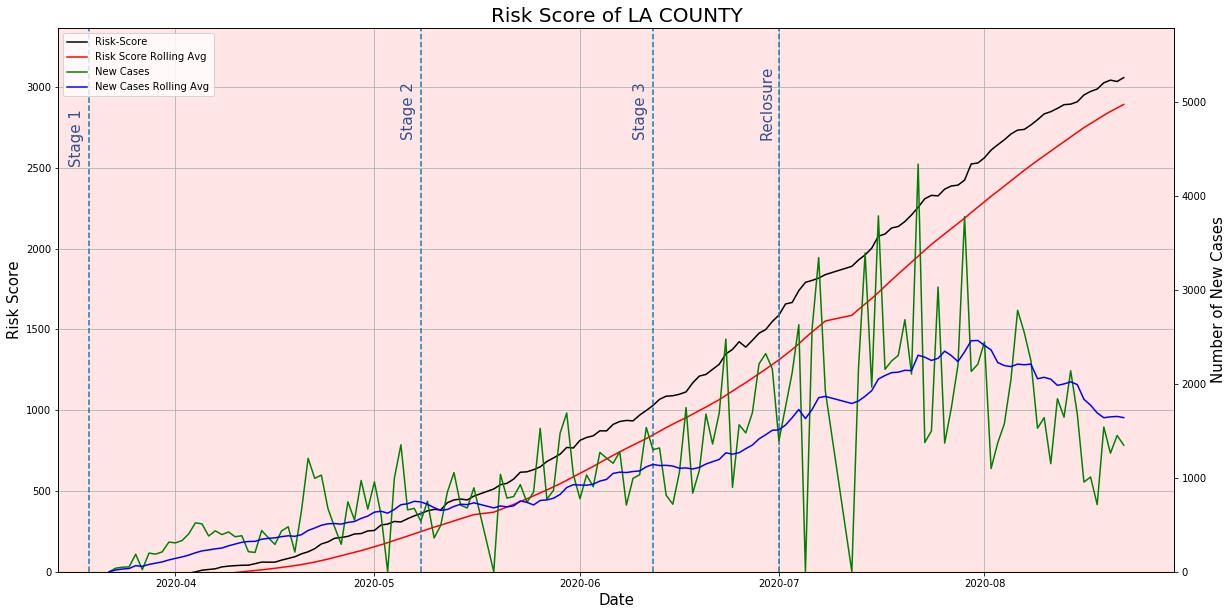

In [18]:
#PRE DROPPED OUTLIERS
plot_rs('LA COUNTY', 18, 'All')

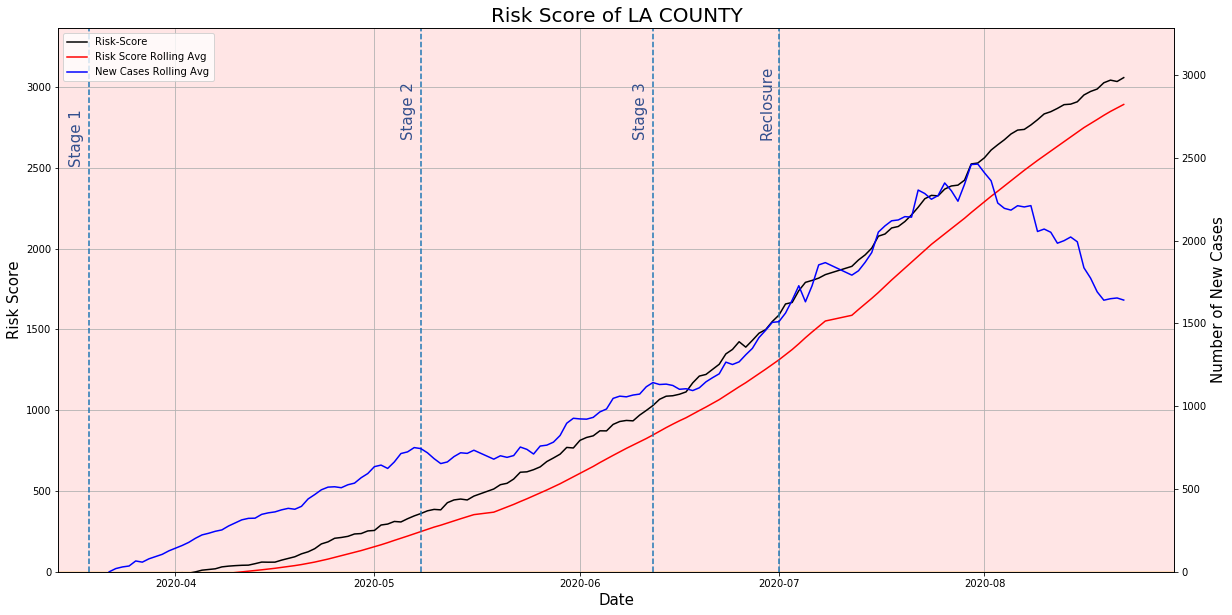

In [19]:
#POST DROPPED OUTLIERS
plot_rs('LA COUNTY', 18, '')

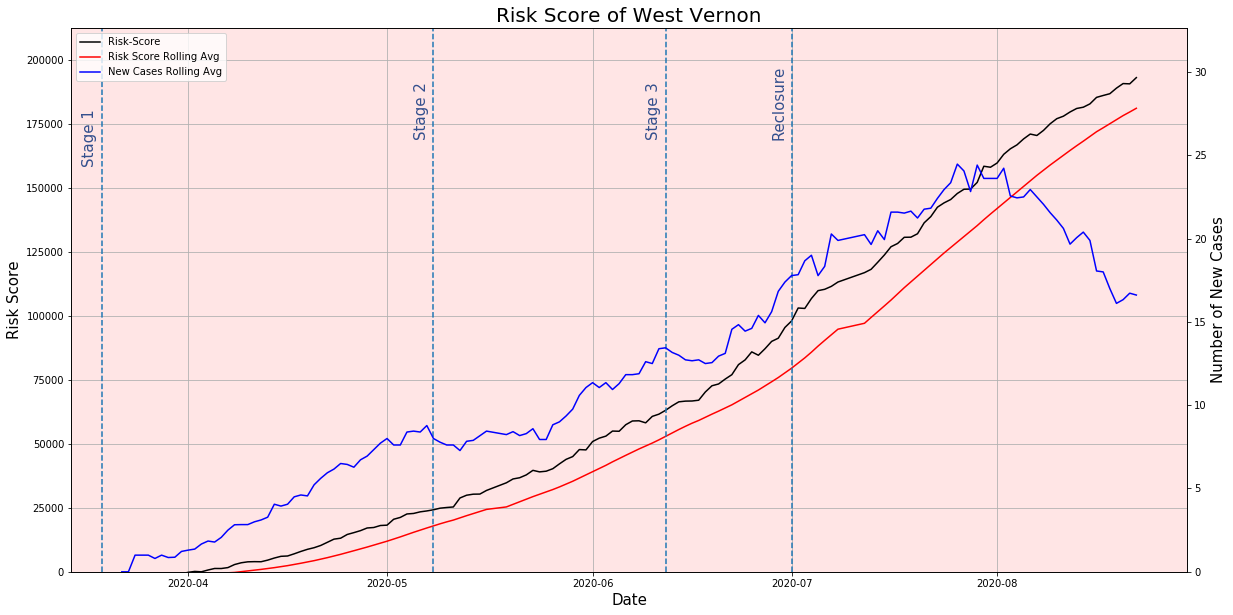

In [20]:
plot_rs('West Vernon', 18, '')

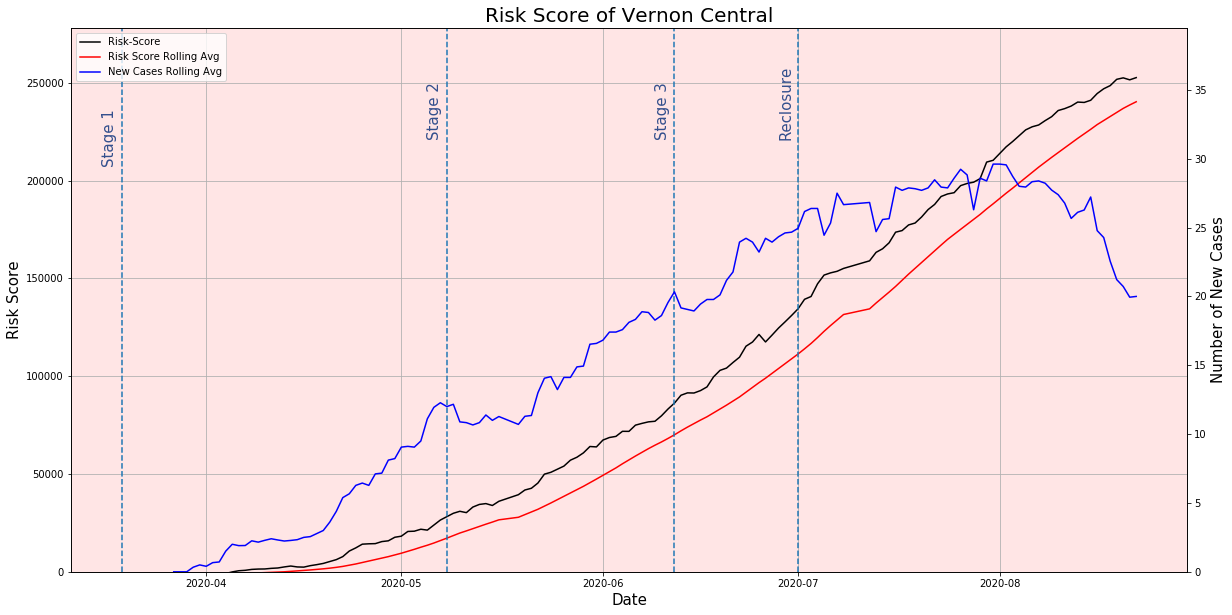

In [21]:
plot_rs('Vernon Central', 18, '')

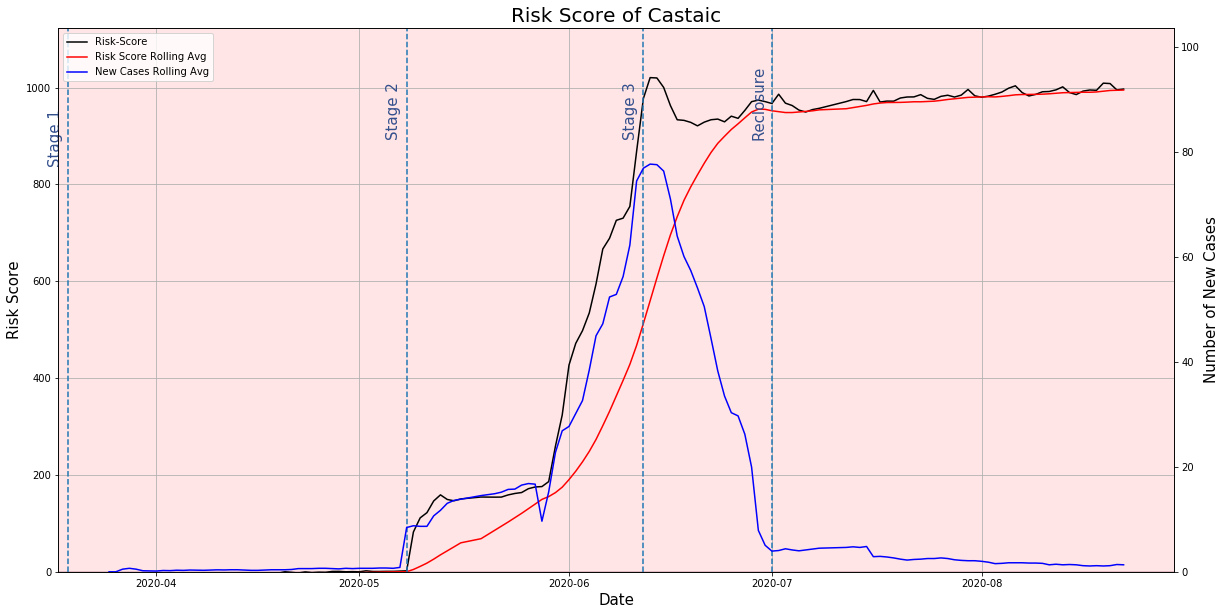

In [34]:
plot_rs('Castaic', 18, '')

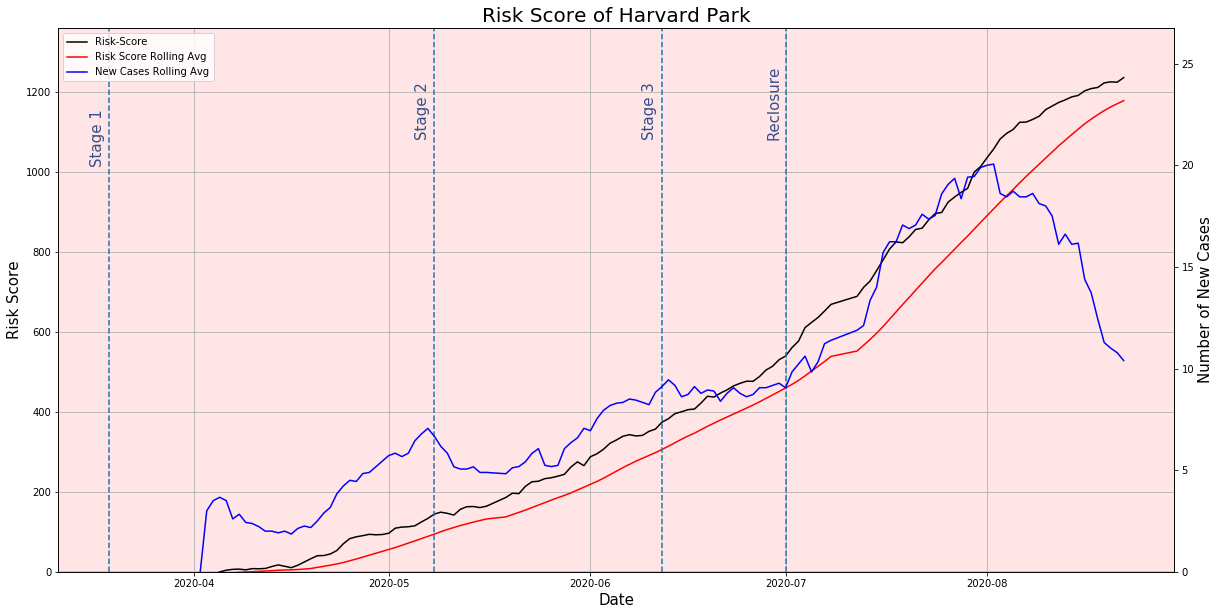

In [23]:
plot_rs('Harvard Park', 18, '')

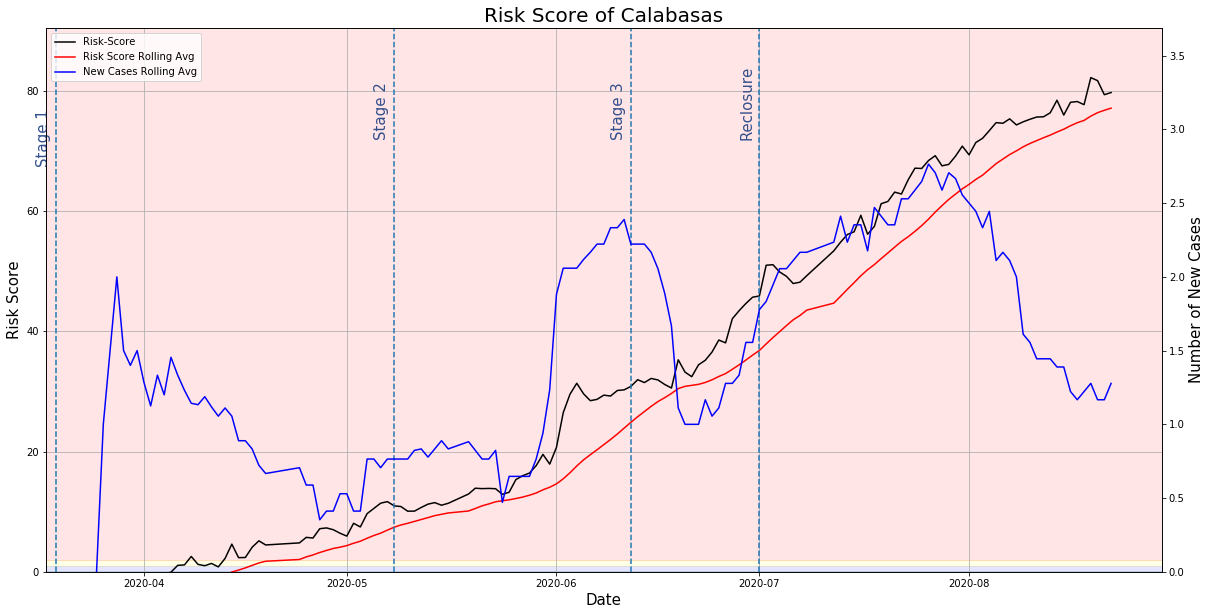

In [24]:
plot_rs('Calabasas', 18, '')

In [25]:
#Calabasas data exploration
df[df['Region'].str.contains("Calabasas")]

,index,Region,Risk-Level,Risk-Score,Time Stamp,Number of cases,New Cases
2522,2619,Calabasas,0,-5.200773,2020-03-25,4.0,NaN
2523,2620,Calabasas,0,-5.491502,2020-03-26,5.0,1.0
2524,2621,Calabasas,0,-5.202172,2020-03-27,7.0,2.0
2525,2622,Calabasas,0,-3.497792,2020-03-28,10.0,3.0
2526,2623,Calabasas,0,-4.145997,2020-03-29,10.0,0.0
2527,2624,Calabasas,0,-3.210837,2020-03-30,11.0,1.0
2528,2625,Calabasas,0,-2.367705,2020-03-31,13.0,2.0
2529,2626,Calabasas,0,-0.573250,2020-04-01,13.0,0.0
2530,2627,Calabasas,0,-0.513587,2020-04-02,13.0,0.0
2531,2628,Calabasas,0,-1.945314,2020-04-03,16.0,3.0


In [26]:
# This function calculates trend of the Risk-Score at the most current data.
# Input:  length1, length2:    these parameters define the windows Risk Score differences
#         rolling_length:      window of the rolling average calculation
#         rolling_diff_length: window used to calculate the rolling average difference
# Output: recent:             this new dataframe contains list of all regions with calculated Risk Score Trends on the most current data

def rs_trend_summary(length1,length2,rolling_length,rolling_diff_length,rs_or_case):
    
    #intializing variables
    recent = pd.DataFrame()
    df_recent_1= pd.DataFrame()
    df_recent_2= pd.DataFrame()
    recent
    
    df_new=df.copy()
    regions = df_new['Region'].unique()
#     recent['Region']=regions
#     recent['Date']=recent['Region']
    
    
    for region in regions:
        df_region = df_new[df_new['Region']==region].sort_values('Time Stamp')
        
        recent_date = max(df_region['Time Stamp'])
#         recent.loc[recent['Region']=='Alhambra','Date'] = recent_date
        
#         length1_bef = pd.to_datetime(recent_date) - dt.timedelta(days=length1)
#         length2_bef = pd.to_datetime(recent_date) - dt.timedelta(days=length2)

#         df_1_before = df_region[df_region['Time Stamp'] == length1_bef]
#         df_2_before = df_region[df_region['Time Stamp'] == length2_bef]
        df_recent = df_region[df_region['Time Stamp']==recent_date]
        
        
        
        #Rolling Avreage
        if rs_or_case == 'rs':
            rolling_rs = df_region['Risk-Score'].rolling(rolling_length, min_periods=1).mean()

            recent_rolling_rs = rolling_rs.iloc[-1]

            length3 = 0 - rolling_diff_length -1

            past_rolling_rs = rolling_rs.iloc[length3]

            rolling_diff_rs = recent_rolling_rs - past_rolling_rs



            df_recent["Current_Rolling_Average"] = recent_rolling_rs
            df_recent["Past_Rolling_Average"] = past_rolling_rs
            df_recent["Rolling AVG Change"] = rolling_diff_rs
        

            threshhold=1/7

            if rolling_diff_rs > threshhold:
                df_recent['Trend (Abs)'] = 'UP'
            if (rolling_diff_rs < threshhold) & (rolling_diff_rs > -threshhold):
                df_recent['Trend (Abs)'] = '-'
            if rolling_diff_rs < -threshhold:
                df_recent['Trend (Abs)'] = 'DOWN'

            percent_change = (rolling_diff_rs)*100/past_rolling_rs
            percent_threshhold = 5
            df_recent['Percent Change']=round(percent_change)

            if percent_change > percent_threshhold:
                df_recent['Trend (%)'] = 'UP'
            if (percent_change < percent_threshhold) & (percent_change > -percent_threshhold):
                df_recent['Trend (%)'] = '-'
            if percent_change < -percent_threshhold:
                df_recent['Trend (%)'] = 'DOWN'
        
#         if rolling_diff > threshhold:
#             df_recent['Risk_Trend_Abs'] = 'Red'
#         if (rolling_diff < threshhold) & (rolling_diff > -threshhold):
#             df_recent['Risk_Trend_Abs'] = 'Yellow'
#         if rolling_diff < -threshhold:
#             df_recent['Risk_Trend_Abs'] = 'Grenn'




        elif rs_or_case == 'case':
            rolling_case = df_region['New Cases'].rolling(rolling_length, min_periods=1).mean()
            recent_rolling_case = rolling_case.iloc[-1]
            length3 = 0 - rolling_diff_length -1
            past_rolling_case = rolling_case.iloc[length3]
            rolling_diff_case = recent_rolling_case - past_rolling_case

            df_recent["Current_Rolling_Average"] = recent_rolling_case
            df_recent["Past_Rolling_Average"] = past_rolling_case
            df_recent["Rolling AVG Change"] = round(rolling_diff_case,5)
            
            threshhold= 3

            if rolling_diff_case > threshhold:
                df_recent['Trend (Abs)'] = 'UP'
            if (rolling_diff_case < threshhold) & (rolling_diff_case > -threshhold):
                df_recent['Trend (Abs)'] = '-'
            if rolling_diff_case < -threshhold:
                df_recent['Trend (Abs)'] = 'DOWN'

            percent_change = (rolling_diff_case)*100/past_rolling_case
            percent_threshhold = 5
            df_recent['Percent Change']=round(percent_change)

            if percent_change > percent_threshhold:
                df_recent['Trend (%)'] = 'UP'
            if (percent_change < percent_threshhold) & (percent_change > -percent_threshhold):
                df_recent['Trend (%)'] = '-'
            if percent_change < -percent_threshhold:
                df_recent['Trend (%)'] = 'DOWN'
        
            
            
            
        
        recent = recent.append(df_recent).sort_values('Time Stamp')
    recent["Rank"] = recent["Rolling AVG Change"].rank()
    recent["Rank"] = recent["Rank"].astype(int)
    recent = recent.sort_values('Rank')
#         recent= recent.rename(columns={"A": "a", "B": "c"})
#         recent=recent.drop(['index','Time Stamp','Latitude', 'Longitude','RS_change_3_Days','RS_change_14_Days'], axis=1)
    recent = recent[['Time Stamp','Region','Number of cases','Risk-Level','Rank','Rolling AVG Change','Trend (Abs)','Percent Change','Trend (%)']]
    return recent

In [27]:
recent = rs_trend_summary(12,13,18,1,'rs')

C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [28]:
recent

,Time Stamp,Region,Number of cases,Risk-Level,Rank,Rolling AVG Change,Trend (Abs),Percent Change,Trend (%)
852,2020-08-22,Avalon,26.0,0,1,-0.723888,DOWN,2.0,-
14145,2020-08-22,Park La Brea,89.0,3,2,0.001946,-,0.0,-
5681,2020-08-22,East Hollywood,547.0,3,3,0.147268,UP,0.0,-
17300,2020-08-22,South Pasadena,241.0,3,4,0.165189,UP,0.0,-
11266,2020-08-22,Los Feliz,173.0,3,5,0.206233,UP,1.0,-
15000,2020-08-22,Rancho Palos Verdes,258.0,3,6,0.208886,UP,0.0,-
17737,2020-08-22,Studio City,215.0,3,7,0.211864,UP,0.0,-
21384,2020-08-22,Westwood,298.0,3,8,0.232647,UP,0.0,-
11711,2020-08-22,Mar Vista,275.0,3,9,0.251228,UP,0.0,-
20065,2020-08-22,Walnut,236.0,3,10,0.263784,UP,0.0,-
